In [1]:
import pandas as pd
import math
from scipy import stats
from scipy import spatial
import numpy as np
import matplotlib.pyplot as plt
from pointpats import PointPattern, as_window
from pointpats import PoissonPointProcess as csr
from pointpats.geometry import (prepare_hull as _prepare_hull, area as _area,
    build_best_tree as _build_best_tree,
    prepare_hull as _prepare_hull,
    TREE_TYPES,
)
from scipy.spatial import distance
from pointpats.ripley import _prepare # very important to prepare data :)

/Users/gocchini/opt/anaconda3/envs/paper_3/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<string>:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.ht

![title](https://slideplayer.com/slide/14868061/90/images/52/adjusting+for+inhomogeneity.jpg)

![text](https://www.routledgehandbooks.com/assets/9781420082555/graphics/equ3_32.jpg)

In [15]:
simulated_companies = pd.read_pickle('/Users/gocchini/Desktop/paper_3/kinhom_work/simuls_df_controls_7.pkl')

In [16]:
# since my dataset is badly formatted, need to flatten it before processing. Assuming it is called df:
simulated_companies.columns = [['lat', 'long']]
def flatten(l):
    return [item for sublist in l for item in sublist]
simulated_companies[['lat', 'long']] = simulated_companies[['lat', 'long']].apply(flatten)
#then go from coords_to_array :)

In [17]:
simulated_companies

,lat,long
0,"[51.471819972612224, 51.36553333217895, 51.506...","[0.014580652465213007, -0.2261973925113902, -0..."
1,"[51.56318321541861, 51.44562745912717, 51.5406...","[-0.03842347003684066, -0.11036908963588887, -..."
2,"[51.52144353984821, 51.52188626631142, 51.5259...","[-0.1295955129957982, -0.1332125664487464, -0...."
3,"[51.61380143560731, 51.58627972082576, 51.5116...","[-0.1439252080315696, -0.2649385248806523, -0...."
4,"[51.48450977484127, 51.6164733547414, 51.50185...","[-0.18605750053720077, -0.09112456786144085, -..."
...,...,...
3,"[51.61380143560731, 51.58627972082576, 51.5116...","[-0.1439252080315696, -0.2649385248806523, -0...."
4,"[51.48450977484127, 51.6164733547414, 51.50185...","[-0.18605750053720077, -0.09112456786144085, -..."
5,"[51.60964644238399, 51.35557649123816, 51.5159...","[-0.29034719542984344, -0.23727390980469665, -..."
6,"[51.60331357835404, 51.62290010686051, 51.4674...","[-0.06864035780212857, -0.27361673620725596, -..."


In [18]:
array_df = coords_to_array(simulated_companies)

In [13]:
def coords_to_array(df): 
    df['array'] = df.apply(lambda x: np.array(list(zip(x['lat'], x['long']))), axis = 1) 
    return df
    
array_df = coords_to_array(simulated_companies)

/var/folders/0f/pzhfvnbj63jg3sk3nj099q3w0000gq/T/ipykernel_76665/1182437683.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df['array'] = df.apply(lambda x: np.array(list(zip(x['lat'], x['long']))), axis = 1)


In [19]:
array_df.head()

,lat,long,array
0,"[51.471819972612224, 51.36553333217895, 51.506...","[0.014580652465213007, -0.2261973925113902, -0...","[[51.471819972612224, 0.014580652465213007], [..."
1,"[51.56318321541861, 51.44562745912717, 51.5406...","[-0.03842347003684066, -0.11036908963588887, -...","[[51.56318321541861, -0.03842347003684066], [5..."
2,"[51.52144353984821, 51.52188626631142, 51.5259...","[-0.1295955129957982, -0.1332125664487464, -0....","[[51.52144353984821, -0.1295955129957982], [51..."
3,"[51.61380143560731, 51.58627972082576, 51.5116...","[-0.1439252080315696, -0.2649385248806523, -0....","[[51.61380143560731, -0.1439252080315696], [51..."
4,"[51.48450977484127, 51.6164733547414, 51.50185...","[-0.18605750053720077, -0.09112456786144085, -...","[[51.48450977484127, -0.18605750053720077], [5..."


# Sample controls and cases from simulations

In [20]:
list_of_arrays = simulated_companies['array'].values.tolist()
sampled_cases = [x[0][np.random.choice(x[0].shape[0], size=5, replace = False), :] for x in list_of_arrays]
simulated_companies['sample_cases'] = sampled_cases
sampled_controls = [x[0][np.random.choice(x[0].shape[0], size=5, replace = False), :] for x in list_of_arrays]
simulated_companies['sample_controls'] = sampled_controls

In [48]:
simulated_companies

,lat,long,array,sample_cases,sample_controls
0,"[51.471819972612224, 51.36553333217895, 51.506...","[0.014580652465213007, -0.2261973925113902, -0...","[[51.471819972612224, 0.014580652465213007], [...","[[51.501567003789006, -0.09347439599380858], [...","[[51.46645704923287, -0.03329927466216426], [5..."
1,"[51.56318321541861, 51.44562745912717, 51.5406...","[-0.03842347003684066, -0.11036908963588887, -...","[[51.56318321541861, -0.03842347003684066], [5...","[[51.51836839554727, -0.16839008219657037], [5...","[[51.592835443911525, -0.021267597166912067], ..."
2,"[51.52144353984821, 51.52188626631142, 51.5259...","[-0.1295955129957982, -0.1332125664487464, -0....","[[51.52144353984821, -0.1295955129957982], [51...","[[51.53568766938471, -0.15296519643099438], [5...","[[51.49822775506927, -0.09290674714164365], [5..."
3,"[51.61380143560731, 51.58627972082576, 51.5116...","[-0.1439252080315696, -0.2649385248806523, -0....","[[51.61380143560731, -0.1439252080315696], [51...","[[51.49946087941606, -0.10727222689368449], [5...","[[51.51453752785353, -0.13815414203657206], [5..."
4,"[51.48450977484127, 51.6164733547414, 51.50185...","[-0.18605750053720077, -0.09112456786144085, -...","[[51.48450977484127, -0.18605750053720077], [5...","[[51.422654933952145, -0.031766708483461414], ...","[[51.47142432092705, -0.13986717592734776], [5..."
...,...,...,...,...,...
3,"[51.61380143560731, 51.58627972082576, 51.5116...","[-0.1439252080315696, -0.2649385248806523, -0....","[[51.61380143560731, -0.1439252080315696], [51...","[[51.467163802423535, -0.08220173343213621], [...","[[51.588920213620966, -0.37529541858104987], [..."
4,"[51.48450977484127, 51.6164733547414, 51.50185...","[-0.18605750053720077, -0.09112456786144085, -...","[[51.48450977484127, -0.18605750053720077], [5...","[[51.528423345846896, -0.15109865276080614], [...","[[51.61631117800485, -0.09713825638676454], [5..."
5,"[51.60964644238399, 51.35557649123816, 51.5159...","[-0.29034719542984344, -0.23727390980469665, -...","[[51.60964644238399, -0.29034719542984344], [5...","[[51.49147715782252, 0.1025212383805304], [51....","[[51.59727780779929, -0.04988939120388569], [5..."
6,"[51.60331357835404, 51.62290010686051, 51.4674...","[-0.06864035780212857, -0.27361673620725596, -...","[[51.60331357835404, -0.06864035780212857], [5...","[[51.53140686212859, -0.14447166085936813], [5...","[[51.51900839432494, -0.057363347388116714], [..."


# Get PDF from controls 

In [66]:
controls = simulated_companies.iloc[2]

In [70]:
controls = pd.DataFrame(controls).T

In [71]:
controls

,lat,long,array,sample_cases,sample_controls
2,"[51.52144353984821, 51.52188626631142, 51.5259...","[-0.1295955129957982, -0.1332125664487464, -0....","[[51.52144353984821, -0.1295955129957982], [51...","[[51.53568766938471, -0.15296519643099438], [5...","[[51.49822775506927, -0.09290674714164365], [5..."


In [72]:
list_of_controls = controls['array'].values.tolist()

In [93]:
x = []
for i in list_of_controls:
    for j in i:
        for f in j:
            x.append(f[0])

y = []
for i in list_of_controls:
    for j in i:
        for f in j:
            y.append(f[1])


In [96]:
x = np.array(x)
y = np.array(y)

In [99]:
values = np.vstack([x, y])
kernel = stats.gaussian_kde(values)

In [98]:
values

array([[ 5.15214435e+01,  5.15218863e+01,  5.15259078e+01, ...,
         5.15098924e+01,  5.15816881e+01,  5.15008786e+01],
       [-1.29595513e-01, -1.33212566e-01, -1.26312571e-01, ...,
        -1.65325910e-01, -9.88724486e-02, -4.71127752e-02]])

# Define functions to find lambdas and calculate kinhom

In [101]:
def find_lambda(kernel, x, y):
    values = np.vstack([x, y])
    return kernel.pdf(values)

def fun_find_kinhom(distance, support, multiplied_lambdas):
    kinhom_values = []
    for x in support:
        if x > distance:
            x = 1/multiplied_lambdas
        else: 
            x = 0 
        kinhom_values.append(x)
    return np.array(kinhom_values)

# Get distances and calculate kinhom on cases

In [107]:
simulated_cases = pd.read_pickle('cases.pkl')
simulated_cases.columns = [['lat', 'long']]
simulated_cases[['lat', 'long']] = simulated_cases[['lat', 'long']].apply(flatten)
cases_df = coords_to_array(simulated_cases)

In [125]:
data = cases_df['array'].values.tolist()[0][0]

In [126]:
data

array([[ 5.14681932e+01, -3.40747753e-01],
       [ 5.15488815e+01, -1.03090107e-02],
       [ 5.16214525e+01, -1.87191053e-01],
       ...,
       [ 5.14601262e+01, -1.26795916e-01],
       [ 5.15813453e+01,  6.64794121e-03],
       [ 5.15478325e+01, -1.45159267e-01]])

# Define distances at which to asses Kinhom

In [123]:
support = [0.        , 0.00584394, 0.01168788, 0.01753182, 0.02337576,
       0.0292197 , 0.03506364, 0.04090759, 0.04675153, 0.05259547]

In [127]:
def find_lambdas_and_distances(array_of_simulated_coordinates, support):
    all_pairs = [(a, b) for idx, a in enumerate(array_of_simulated_coordinates) for b in array_of_simulated_coordinates[idx + 1:]]
    df = pd.DataFrame(all_pairs)
    df.columns = [['x', 'y']]
    df['lambda_values_x'] = df.apply(lambda x: find_lambda(kernel, x['x'][0], x['x'][1]), axis = 1) 
    df['lambda_values_y'] = df.apply(lambda x: find_lambda(kernel, x['y'][0], x['y'][1]), axis = 1)
    df['inhom_lambda'] = df.apply(lambda x: x['lambda_values_x']*x['lambda_values_y'], axis =1) 
    df['distance'] = df.apply(lambda x: distance.euclidean(x['x'], x['y']), axis = 1)
    support_names = map(str, support)
    support_pd = pd.DataFrame(zip(support_names, support),
               columns =['distance_name', 'distance'])
    support_pd = support_pd.T
    support_pd.columns = support_pd.iloc[0]
    support_pd = support_pd.iloc[1: , :]
    support_pd = pd.DataFrame(np.repeat(support_pd.values, len(df), axis = 0))
    support_pd.columns = support_pd.iloc[0]
    support_pd['support'] = support_pd.values.tolist()
    df = pd.concat([df, support_pd['support']], axis=1)
    df.columns = [['x', 'y', 'lambda_values_x','lambda_values_y', 'multiplied_lambdas', 'distance', 'support']]
    df['kinhom'] = df.apply(lambda x: fun_find_kinhom(x['distance'], x['support'], x['multiplied_lambdas']), axis = 1)
    n_pairs_less_than_d = df['kinhom'].values.tolist()
    internal_argument = np.sum(n_pairs_less_than_d, 0)
    return df, n_pairs_less_than_d, internal_argument

In [128]:
kinhoms = find_lambdas_and_distances(data, support)

/var/folders/0f/pzhfvnbj63jg3sk3nj099q3w0000gq/T/ipykernel_76665/3229891459.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(kinhom_values)


In [129]:
kinhoms[0]

,x,y,lambda_values_x,lambda_values_y,multiplied_lambdas,distance,support,kinhom
0,"[51.468193164170934, -0.34074775313951944]","[51.54888154756644, -0.010309010705312593]",[3.3774348427285332],[9.546515772948514],[32.24273499821383],0.340148,"[0.0, 0.00584394, 0.01168788, 0.01753182, 0.02...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,"[51.468193164170934, -0.34074775313951944]","[51.621452489635296, -0.18719105317653056]",[3.3774348427285332],[7.750608485275469],[26.17717515051679],0.216952,"[0.0, 0.00584394, 0.01168788, 0.01753182, 0.02...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,"[51.468193164170934, -0.34074775313951944]","[51.530915635313, -0.15371214775888425]",[3.3774348427285332],[37.02297438486922],[125.0426836689033],0.197272,"[0.0, 0.00584394, 0.01168788, 0.01753182, 0.02...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,"[51.468193164170934, -0.34074775313951944]","[51.46265412980237, -0.19012951299805264]",[3.3774348427285332],[9.37660878840746],[31.66888522860193],0.150720,"[0.0, 0.00584394, 0.01168788, 0.01753182, 0.02...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"[51.468193164170934, -0.34074775313951944]","[51.45039782036547, -0.04048566340890164]",[3.3774348427285332],[5.396367937015943],[18.22588109466074],0.300789,"[0.0, 0.00584394, 0.01168788, 0.01753182, 0.02...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...
540275,"[51.35977051002052, -0.09033169064702062]","[51.58134530774247, 0.00664794121226886]",[1.7218158741620144],[10.546699108705331],[18.159473945379208],0.241869,"[0.0, 0.00584394, 0.01168788, 0.01753182, 0.02...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
540276,"[51.35977051002052, -0.09033169064702062]","[51.54783245337919, -0.1451592670607011]",[1.7218158741620144],[25.132506697136147],[43.273548988612156],0.195891,"[0.0, 0.00584394, 0.01168788, 0.01753182, 0.02...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
540277,"[51.46012621978864, -0.126795916121335]","[51.58134530774247, 0.00664794121226886]",[11.1486502688976],[10.546699108705331],[117.58145985424976],0.180281,"[0.0, 0.00584394, 0.01168788, 0.01753182, 0.02...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
540278,"[51.46012621978864, -0.126795916121335]","[51.54783245337919, -0.1451592670607011]",[11.1486502688976],[25.132506697136147],[280.19352754709763],0.089608,"[0.0, 0.00584394, 0.01168788, 0.01753182, 0.02...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [130]:
kinhoms[1]

[[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, array([0.10881256]), array([0.10881256]),
         array([0.10881256]), array([0.10881256])], dtype=object)],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0,

In [131]:
kinhoms[2]

array([[0, array([14.1325988]), array([63.22523872]),
        array([124.59054971]), array([196.59984312]),
        array([292.78245647]), array([404.55983713]),
        array([533.63251202]), array([678.78252395]),
        array([840.34420997])]], dtype=object)

# Calculate hull on full set

In [132]:
coords_array = list_of_arrays[0][0]
hull = _prepare_hull(coords_array)

In [133]:
one_divided_area = 1/_area(hull)
K = kinhoms[2]*one_divided_area

In [134]:
K

array([[0.0, array([51.10850107]), array([228.64493825]),
        array([450.56371662]), array([710.97491915]),
        array([1058.80543958]), array([1463.03218215]),
        array([1929.80485671]), array([2454.71889715]),
        array([3038.98338501])]], dtype=object)

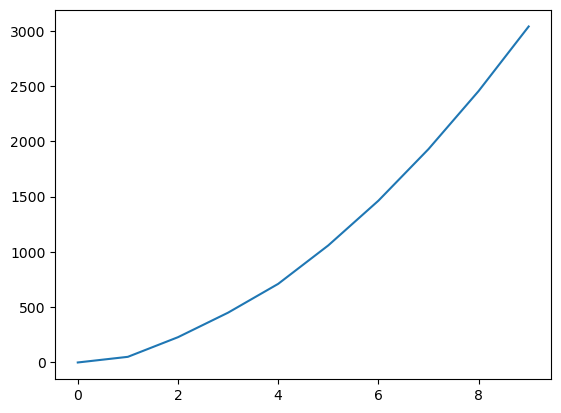

In [141]:
plt.plot(K[0])

# Transform to L 

In [135]:
def L_function(list_of_estimates):
    L = [math.sqrt(x/math.pi) for x in list_of_estimates]
    return L
#kinhom_estimates['l_estimates'] = kinhom_estimates['kinhom_estimate'].apply(L_function)